# Statistical analysis of the generated cell positions

In [1]:
import numpy as np
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt

from sklearn.neighbors import NearestNeighbors

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  


## Load data

In [3]:
fname = "../../test_data/generated_positions/coords_20190626_1_6.npz"
f = np.load(fname)
f['grc_nop'].shape # grc_nop is grc positions without perturbation

(267187, 3)

In [19]:
def limit_to_box(x, box):
    """select only the points within a given box."""
    mf = x.copy()
    for i, t in enumerate(box):
        mf = mf[mf[:, i] >= t[0], :]
        mf = mf[mf[:, i] <= t[1], :]
    return mf

def print_range(goc):
    """prints the 3d range occupied by the cell population"""
    print(
        "Current range:\n",
        "x: [{}, {}]\n".format(goc[:, 0].min(), goc[:, 0].max()),
        "y: [{}, {}]\n".format(goc[:, 1].min(), goc[:, 1].max()),
        "z: [{}, {}]".format(goc[:, 2].min(), goc[:, 2].max()),
    )

def fix_coords(x, bbox):
    """removes the cells in a 25 um-wide gutter."""
    y = x - 25
    y = limit_to_box(y, bbox)
    print_range(y)
    return y


bbox = [[0, 700], [0, 700], [0, 200]]
grc = fix_coords(f['grc_nop'], bbox) # here we use the unperturbed position
glo = fix_coords(f['glo'], bbox)
grx = grc + np.random.randn(*grc.shape)*0.2 # add perturbation of 0.2 um here

Current range:
 x: [0.0016037355951397103, 699.9972531094394]
 y: [0.00013368484322029417, 699.9949118783769]
 z: [0.0007851149859412487, 199.99800821835984]
Current range:
 x: [0.012733730993307546, 699.9814859270571]
 y: [0.002184874849444185, 699.989912662634]
 z: [0.006066884183795196, 199.99994888258348]


## GrC position analysis
### Nearest neighbor histogram

In [23]:
nn = NearestNeighbors()
nn.fit(grx)
dists, nnids = nn.kneighbors(grx, n_neighbors=2, return_distance=True)

nn.fit(grc)
dists_u, nnids = nn.kneighbors(grc, n_neighbors=2, return_distance=True)

nnids = nnids[:,1]
dists = dists[:,1]

dists_u = dists_u[:,1]

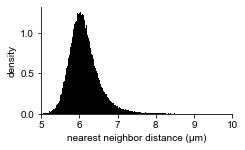

In [24]:
_, ax = plt.subplots(figsize=(8.9/2.54, 8.9/2.54*5/8))
ax.hist(dists, 450, density=True, color='k')
# _ = plt.hist(dists_u, 500)
ax.set(
    xlim=[5, 10],
    xlabel='nearest neighbor distance (μm)',
    ylabel='density'
)
plt.tight_layout()
plt.savefig('nn_dist_hist.png', dpi=600)

### Pair correlation function

In [12]:
gry = limit_to_box(grx, [[30, 670], [30, 670], [30, 170]])

nn = NearestNeighbors(n_jobs=-1)
nn.fit(grx)

mcounts = []
sdcounts = []
dists = np.linspace(0, 30, 240)
for r in tqdm(dists):
    count = np.frompyfunc(lambda x: x.size, 1, 1)(nn.radius_neighbors(
        gry, radius=r, return_distance=False
    )).astype(float) - 1
    mcounts.append(count.mean())
    sdcounts.append(count.std()/np.sqrt(count.size))

# mcount = count.mean()
# sdcount = count.std()
# print('{} ± {}'.format(mcount, sdcount))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


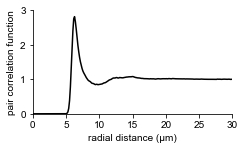

In [13]:
cc2 = np.gradient(mcounts)/(dists**2)
cc2_0 = cc2[-1]
cc2 = cc2/cc2_0

mcounts = np.array(mcounts)
sdcounts = np.array(sdcounts)

cc2_u = np.gradient(mcounts + 150*sdcounts)/(dists**2+0.001)/cc2_0
cc2_d = np.gradient(mcounts - 150*sdcounts)/(dists**2+0.001)/cc2_0
# plt.fill_between(dists, cc2_d, cc2_u)
# plt.fill_between(dists, cc2_d, cc2_u, alpha=0.5)


_, ax = plt.subplots(figsize=(8.9/2.54, 8.9/2.54*5/8))
ax.plot(dists, cc2, 'k')
ax.set(
    ylim = [0, 3],
    xlim = [0, 30],
    xlabel='radial distance (μm)',
    ylabel='pair correlation function'
)
plt.tight_layout()
plt.savefig('cc2_grc.png', dpi=600)

### Anglular distribution

In [14]:
nn.fit(grx)
gry = limit_to_box(grx, [[30, 670], [30, 670], [30, 170]])
nnids = nn.kneighbors(gry, n_neighbors=2, return_distance=False)
nnids = nnids[:,1]

In [15]:
# print(grx.shape)
# print(gry.shape)
nn_gry = grx[nnids,:]
dvec = nn_gry-gry
dvec

from numpy.linalg import norm
dst_dvec = norm(dvec, axis=-1)
dvec2 = dvec[:,0:2]
l2_dvec2 = norm(dvec2, axis=-1)

cos_theta = dvec2[:,0]/l2_dvec2
sin_theta = dvec2[:,1]/l2_dvec2

theta = np.arctan2(sin_theta, cos_theta)

Text(0.5, 0, 'angle from sagittal')

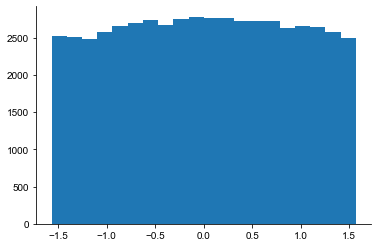

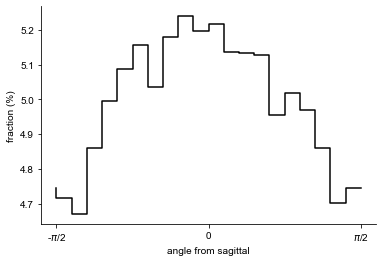

In [16]:
xx = np.linspace(-np.pi/2, np.pi/2, 21)
n, x, _ = plt.hist((theta), xx)

xtickloc = np.linspace(-np.pi/2, np.pi/2, 3)
n = n/sum(n)*100
_, ax = plt.subplots()
# ax.bar(x[:-1], n)
ax.step(x, np.hstack([n, n[0]]), 'k')
# ax.set_ylim([2050, 2300])
ax.set_xticks(xtickloc)
ax.set_xticklabels([r'-$\pi$/2', '0', r'$\pi$/2'])
ax.set_ylabel('fraction (%)')
ax.set_xlabel('angle from sagittal')

In [17]:
(n.max()-n.min())/n.min()

0.12187247780468109

## Simple distance-based GrC-Glomeruli connection

In [18]:
grx = np.random.rand(*grx.shape)
glo = np.random.rand(*glo.shape)

grx[:,0] *= 700
grx[:,1] *= 700
grx[:,2] *= 200

glo[:,0] *= 700
glo[:,1] *= 700
glo[:,2] *= 200

In [7]:
scale_factor = 1/4

# grx = grc + np.random.randn(*grc.shape)*0.2

src = grx.copy()
tgt = glo.copy()
src[:, 1] *= scale_factor
tgt[:, 1] *= scale_factor

N conns = 4.448358435724667 ± 1.3655273005984814


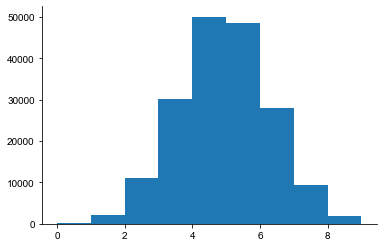

In [8]:
rr = 7.85
nn = NearestNeighbors()
nn.fit(tgt)
conns = nn.radius_neighbors(src, radius=rr, return_distance=False)
nconns = np.frompyfunc(lambda x: x.size, 1, 1)(conns).astype(int)

n_r, x_r, _ = plt.hist(nconns,np.arange(nconns.max()),100)
print('N conns = {} ± {}'.format(np.mean(nconns), np.std(nconns)))
      
# conns = nn.kneighbors(src, n_neighbors=2, return_distance=False)

N conns = 4.24962677728382 ± 2.1087909181079714


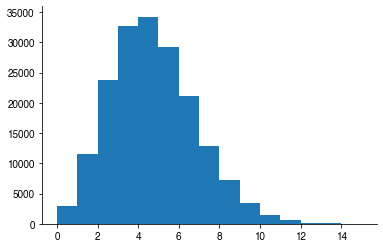

In [20]:
nn = NearestNeighbors()
nn.fit(tgt)
conns = nn.radius_neighbors(src, radius=rr, return_distance=False)
nconns = np.frompyfunc(lambda x: x.size, 1, 1)(conns).astype(int)
nc, xc, _ = plt.hist(nconns, np.arange(nconns.max()), 100)
print('N conns = {} ± {}'.format(np.mean(nconns), np.std(nconns)))
      
# conns = nn.kneighbors(src, n_neighbors=2, return_distance=False)

<BarContainer object of 15 artists>

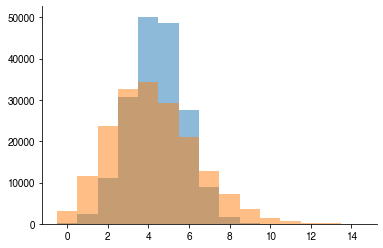

In [21]:
plt.bar(x_r[:-1], n_r, 1, alpha=0.5)
plt.bar(xc[:-1], nc, 1, alpha=0.5)

In [22]:
2.126870358595118/1.364489593641605

1.5587296293838637

In [49]:
print(np.sum(n_r[x_r[:-1]>7])/sum(n_r)*100)
print(np.sum(nc[xc[:-1]>7])/sum(nc)*100)
print(np.sum(n_r[x_r[:-1]<3])/sum(n_r)*100)
print(np.sum(nc[xc[:-1]<3])/sum(nc)*100)

1.0874475281777816
7.229818318037086
7.4859799698114875
21.105516565120148


(0, 10.1)

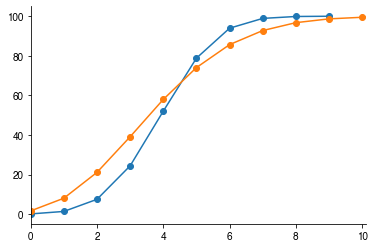

In [55]:
plt.plot(np.cumsum(n_r)/np.sum(n_r)*100,'o-')
plt.plot(np.cumsum(nc)/np.sum(nc)*100,'o-')
plt.xlim([0, 10.1])

In [15]:
dendvs = np.vstack([glo[conn,:] - grc[i,:] for i, conn in enumerate(conns) if conn.size>1])
dendlens = np.sqrt((dendvs**2).sum(axis=-1))
dendlens

array([ 9.81717331,  7.8891964 ,  7.45201683, ...,  7.52792657,
       23.733342  , 13.10967186])

13.468779536898543±5.80989185651278


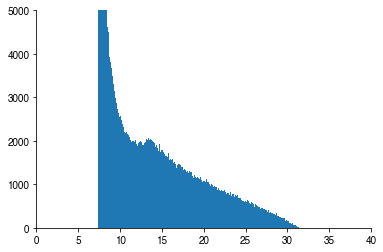

In [16]:
plt.hist(dendlens,500)
plt.xlim([0, 40])
plt.ylim([0, 5000])
print('{}±{}'.format(dendlens.mean(), dendlens.std()))

8.57629629984314±2.8212765699243687
31.504242686465453±10.741608911979984


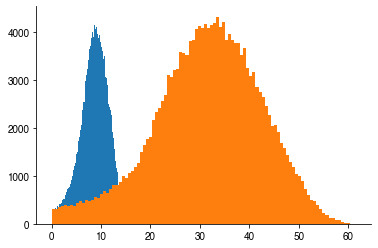

In [17]:
dendvs = [glo[conns[i],:] - grc[i,:] for i, conn in enumerate(conns) if conn.size>1]

ml_spread = np.array([z[:,0].max()-z[:,0].min() for z in dendvs])

plt.hist(ml_spread,100)
print('{}±{}'.format(ml_spread.mean(), ml_spread.std()))

sg_spread = np.array([z[:,1].max()-z[:,1].min() for z in dendvs])

plt.hist(sg_spread,100)
print('{}±{}'.format(sg_spread.mean(), sg_spread.std()))

### Relative variability

In [72]:
scale_factor = 1/4
gry = limit_to_box(grx, [[40, 660], [40/scale_factor, 700-40/scale_factor], [0, 200]])
src = gry.copy()
tgt = glo.copy()
src[:, 1] *= scale_factor
tgt[:, 1] *= scale_factor

In [ ]:
nn = NearestNeighbors(n_jobs=-1)
nn.fit(tgt)
# conns = nn.radius_neighbors(src, radius=7, return_distance=False)
# nconns = np.frompyfunc(lambda x: x.size, 1, 1)(conns).astype(int)
# _ = plt.hist(nconns,np.arange(nconns.max()),100)
# print('Mean connection = {}'.format(np.mean(nconns)))

mcounts = []
vcounts = []
dists0 = np.linspace(1, 40, 120)
for r in tqdm(dists0):
    count = np.frompyfunc(lambda x: x.size, 1, 1)(nn.radius_neighbors(
        src, radius=r, return_distance=False
    )).astype(float)
    mcounts.append(count.mean())
    vcounts.append(count.var())

In [478]:
mcounts0 = np.array(mcounts)
vcounts0 = np.array(vcounts)

In [479]:
ii = (mcounts0>0) * (mcounts0 < 60)
mcounts = mcounts0[ii]
dists = dists0[ii]
vcounts = vcounts0[ii]

In [480]:
mcr = np.interp(dists, dists_r, ((vcounts_r)/mcounts_r))

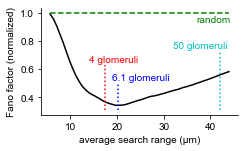

In [573]:
 _, ax = plt.subplots(figsize=(8.9/2.54, 8.9/2.54*5/8))
#_, ax = plt.subplots()

# ax.plot(
#      mcounts, ((vcounts)/mcounts)/mcr, 'k',
#      mcounts, mcr/mcr, '--g'
# )


ax.plot(
    2.128*dists, (((vcounts)/mcounts)/mcr), 'k',
    2.128*dists, mcr/mcr, '--g'
)
ax.plot(np.array([20.26, 20.26]), [0.31, 0.5], ':b')
ax.annotate('6.1 glomeruli', [20.-1, 0.52], color='b')
ax.plot(np.array([17.47, 17.47]), [0.31, 0.63], ':r')
ax.annotate('4 glomeruli', [17.-3, 0.65], color='r')
ax.annotate('50 glomeruli', [32., 0.75], color='c')
ax.plot(np.array([42., 42.]), [0.31, 0.72], ':c')

ax.annotate('random', [37, 0.93], color='g')

ax.set(
#     xticks=np.arange(0, 44, 4),
    xlabel='average search range (μm)',
    ylabel='Fano factor (normalized)'
)

plt.tight_layout()
plt.savefig('var_conns.png', dpi=300)

# plt.xlim([0, 60])

# plt.ylim([-0.02, 0.02])